In [1]:
import json
import re
import random
import evaluate
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the .jsonl files
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return data

train_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_train.jsonl")
val_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_dev.jsonl")
test_data = load_jsonl("C:/Users/Administrator/Desktop/final_project/hindi_test.jsonl")

In [3]:
# Sample data to reduce training time
def sample_data(dataset, num_samples):
    return random.sample(dataset, num_samples)

train_data_sampled = sample_data(train_data, 8000)
val_data_sampled = sample_data(val_data, 1500)
test_data_sampled = sample_data(test_data, 500)

In [4]:
# Convert to Hugging Face dataset format
train_dataset = Dataset.from_list(train_data_sampled)
val_dataset = Dataset.from_list(val_data_sampled)
test_dataset = Dataset.from_list(test_data_sampled)

# Create DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


In [5]:
# Clean Text Function
def clean_text(sample):
    text = re.sub(r"[.]{2,}", ".", sample['text'])  # Remove multiple dots
    text = re.sub(r"_+", "", text)  # Remove blank spaces or underscores
    return {'text': text.strip(), 'title': sample['title'].strip()}

# Apply cleaning function
dataset = dataset.map(clean_text)

Map: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 9284.12 examples/s]


In [6]:
# Tokenizer & Model - Standard fine-tuning (no LoRA)
model_name = "ai4bharat/IndicBART-XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Tokenize the dataset
def preprocess(batch):
    inputs = [f"<2hi> {text}" for text in batch['text']]
    targets = batch['title']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=32, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized = dataset.map(preprocess, batched=True, remove_columns=['id', 'url', 'category'])

Map: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2421.55 examples/s]


In [7]:
import evaluate

# Load all metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    
    # BLEU
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    
    # METEOR
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    
    # BERTScore (language should match your data — "hi" for Hindi, "en" for English, etc.)
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="hi")

    return {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"],
        "meteor": meteor_result["meteor"],
        "bertscore_f1": sum(bertscore_result["f1"]) / len(bertscore_result["f1"])  # average F1 score
    }


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
# Training arguments - Adjusted for standard fine-tuning
training_args = Seq2SeqTrainingArguments(
    output_dir="./indicbart_standard_hindi_copy",
    per_device_train_batch_size=8,  # Reduced batch size due to higher memory requirements
    per_device_eval_batch_size=8,
    eval_strategy="epoch",  # This parameter is now defined only once
    learning_rate=5e-5,  # Lower learning rate for standard fine-tuning
    num_train_epochs=15,  # Reduced epochs as standard fine-tuning may converge faster
    save_total_limit=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none",
    generation_max_length=32,
    # eval_strategy="epoch",  # Removed duplicate parameter
    save_strategy="epoch"  # Ensure this is set
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['validation'],  # Changed from evaluation_dataset to eval_dataset as per standard API
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics
)  # Added the missing closing parenthesis here

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2400\796200271.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
history = trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Meteor,Bertscore F1
1,2.479900,1.356638,0.721852,0.428475,0.722079,0.179674,0.349623,0.773702
2,1.346000,1.265176,0.721605,0.432150,0.721805,0.185069,0.356614,0.776437
3,1.253500,1.245215,0.717751,0.423967,0.717969,0.188803,0.364404,0.779304
4,1.201200,1.224095,0.722096,0.431044,0.722309,0.189617,0.365440,0.779940
5,1.156700,1.215044,0.719816,0.425120,0.719910,0.189801,0.370119,0.780269
6,1.122900,1.209622,0.721637,0.428969,0.721989,0.191006,0.368134,0.779563
7,1.095200,1.204990,0.723376,0.436248,0.723407,0.190758,0.371400,0.780702
8,1.069100,1.200458,0.723878,0.439068,0.724105,0.193782,0.376028,0.782372
9,1.049200,1.199383,0.725351,0.443857,0.725598,0.190660,0.374585,0.781099
10,1.031500,1.198199,0.722635,0.436459,0.722602,0.190312,0.373766,0.781127


In [11]:
# Save the model
trainer.save_model("./working/checkpoints/indicbart_standard_hindi_final_copy1")
tokenizer.save_pretrained("./working/checkpoints/indicbart_standard_hindi_final_copy1")

('./working/checkpoints/indicbart_standard_hindi_final_copy1\\tokenizer_config.json',
 './working/checkpoints/indicbart_standard_hindi_final_copy1\\special_tokens_map.json',
 './working/checkpoints/indicbart_standard_hindi_final_copy1\\spiece.model',
 './working/checkpoints/indicbart_standard_hindi_final_copy1\\added_tokens.json',
 './working/checkpoints/indicbart_standard_hindi_final_copy1\\tokenizer.json')

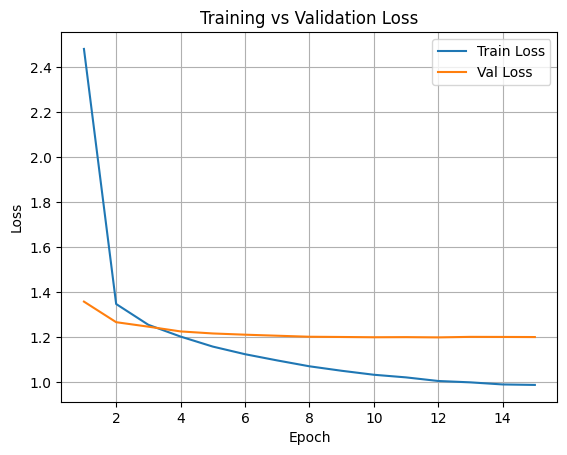

In [12]:
import matplotlib.pyplot as plt

train_loss = []
train_epochs = []
val_loss = []
val_epochs = []

for log in trainer.state.log_history:
    if 'loss' in log and 'eval_loss' not in log:
        train_loss.append(log['loss'])
        train_epochs.append(log.get('epoch', len(train_epochs)))
    elif 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        val_epochs.append(log.get('epoch', len(val_epochs)))

plt.plot(train_epochs, train_loss, label="Train Loss")
plt.plot(val_epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("C:/Users/Administrator/Desktop/final_project/without lora/working/checkpoints/indicbart_standard_hindi_final_copy1")
tokenizer = AutoTokenizer.from_pretrained("C:/Users/Administrator/Desktop/final_project/without lora/working/checkpoints/indicbart_standard_hindi_final_copy1")

In [14]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized['test'])
print(f"Test results: {test_results}")


Test results: {'eval_loss': 3.1922986507415771, 'eval_rouge1': 0.49395793650793645, 'eval_rouge2': 0.32422380952380953, 'eval_rougeL': 0.51970079365079365, 'eval_bleu': 0.1582090184371348, 'eval_meteor': 0.2878668743707685, 'eval_bertscore_f1': 0.7563295886516571, 'eval_runtime': 36.929, 'eval_samples_per_second': 13.54, 'eval_steps_per_second': 1.706, 'epoch': 15.0}


In [15]:

test_texts = [sample['text'] for sample in dataset['test']]
test_titles = [sample['title'] for sample in dataset['test']]


def generate_summaries(texts):
    summaries = []
    for text in texts:
        inputs = tokenizer(f"<2hi> {text}", max_length=512, truncation=True, padding="max_length", return_tensors="pt")
        input_ids = inputs.input_ids.to(model.device)
        attention_mask = inputs.attention_mask.to(model.device)
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            num_beams=4,
            early_stopping=True
        )
        
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

In [16]:
preds = generate_summaries(test_texts)

In [17]:
# Save predictions to .jsonl file
with open("predicted_headlines.jsonl_copy", "w", encoding="utf-8") as f:
    for i in range(len(preds)):
        json.dump({
            "text": test_texts[i],
            "Actual headline": test_titles[i],
            "Predicted headline": preds[i]
        }, f, ensure_ascii=False)
        f.write("\n")

In [18]:

for i in range(min(5, len(preds))):  
    out = {
        "text": test_texts[i],
        "Actual headline": test_titles[i],
        "Predicted headline": preds[i]
    }
    print(out)

{'text': 'बुधवार को सुनवाई के दौरान जस्टिस एके सीकरी की अध्यक्षता वाली पीठ ने कुमार से आग्रह किया। उस समय कोर्ट में मौजूद कुमार से पीठ ने पूछा कि क्या वह मामले में एमिकस क्यूरी के रूप में सहायता कर सकते हैं। उन्होंने इस आग्रह को स्वीकार कर लिया। पीठ के सामने मामले में एमिकस क्यूरी की नियुक्ति का मामला उठाया गया था। इसके बाद पीठ ने मामले की सुनवाई पांच फरवरी तय कर दी।\nकोर्ट से मामले में हस्तक्षेप की मांग करते हुए अर्जी दायर करने वाले वकील ने पीठ से कहा कि जगन्नाथ मंदिर के बारे में जानकारी रखने वाले को ही एमिकस के रूप में नियुक्त किया जाए।', 'Actual headline': 'जगन्नाथ मंदिर मामले में सुप्रीम कोर्ट ने रंजित कुमार को एमिकस बनाया', 'Predicted headline': 'जगन्नाथ मंदिर के बारे में जानकारी रखने वाले को एमिकस के रूप में नियुक्त करे सरकार'}
{'text': 'अभिनेत्री प्रियंका चोपड़ा ने इंस्टाग्राम पर दिखाया कि उन्हें कॉन्सर्ट नाइट के बाद अपने पॉप स्टार पति निक जोनस को कैसे गले लगाना पसंद है। प्रियंका ने रविवार को अपनी इंस्टाग्राम स्टोरी पर जोनस ब्रदर शो के बाद की अपनी और निक की तस्वीरें साझा की।\nउन